Заполненный ноутбук в колабе: https://colab.research.google.com/drive/1dqq5e-c_yMrpiKpXGn4NzFQ0_3OOSCwO?usp=sharing

In [1]:
import math
import os
import random
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from tqdm.auto import tqdm


%matplotlib inline
warnings.filterwarnings("ignore")

## Методы оптимизации
Как вам показали на лекции, большинство методов машинного обучения сводятся к простому поиску параметров, который бы минимизировал ошибку на тренировочной выборке:
$$
\min_{\theta} \sum_{x \in X_{test}} L(p_{\theta}(x), y)
$$
Здесь:
* $L$ - некоторый лосс,
* $p_{\theta}$ - нейронная сеть с параметрами $\theta$,
* $X$ - данные для обучения,
* $y$ - ответы

Напишем алгоритм для поиска минимума некоторой функции
$$
f(x) = x^{3} + 2x^{2} + 2
$$

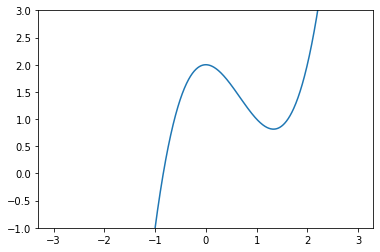

In [2]:
# Наша функция f(x)
func = lambda x: x ** 3 - 2 * x ** 2 + 2

# Производная функции f(x)
d_func = lambda x: 3 * x ** 2 - 4 * x

# Сделаем массив из 1000 элементов от -3 до 3
x = np.linspace(-3, 3, 1000)

# Определим границы по y для графика
plt.ylim([-1, 3])
plt.plot(x, func(x))
plt.show()

Определим функцию для оптимизации $f(x)$, которая должна принимать на вход learning rate, максимальное количество итераций

In [3]:
def find_minimum_first_order(
    learning_rate=0.01,
    eps=1e-4,
    max_iterations=1000,
    anneal_learning_rate=None
):
    i = 0
    x_old, x_new = 0, 2
    # Будем сохранятся обновлённые значения x и y
    x_list, y_list = [x_old], [func(x_old)]
    if not anneal_learning_rate:
        anneal_learning_rate = lambda lr, step: lr
    # TODO:
    # Your code here
    # --------------
    while abs(x_new - x_old) > eps and i < max_iterations:
        # Получим learning rate для текущей итерации
        learning_rate = anneal_learning_rate(learning_rate, step=i)
        # Обновим x_old
        x_old = x_new
        # Сделаем один шаг gradient descent
        x_new = x_old - learning_rate * d_func(x_old)
        # Добавим новые значения для визуализации сходимости
        x_list.append(x_new)
        y_list.append(func(x_new))
        i += 1
    # --------------
    print("Найденный локальный минимум:", x_new)
    print("Количество шагов:", len(x_list))
    # Визуализируем сходимость
    plt.figure(figsize=[6, 4])
    plt.ylim([-3, 8])
    plt.scatter(x_list, y_list, c="r", edgecolors='k')
    plt.plot(x_list, y_list, c="r")
    plt.plot(x, func(x), c="b")
    plt.title("Descent trajectory")
    plt.show()

Попробуем различные learning rate и посмотрим на поведение оптимизации

Найденный локальный минимум: 1.3577577123861129
Количество шагов: 729


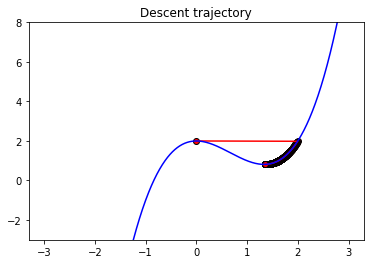

In [4]:
find_minimum_first_order(0.001)

Слишком мало, будем очень долго идти к локальному минимуму

Найденный локальный минимум: 1.3356881625009205
Количество шагов: 129


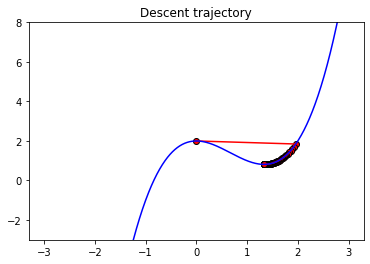

In [5]:
find_minimum_first_order(0.01)

Уже лучше

Найденный локальный минимум: 1.3333495713163788
Количество шагов: 8


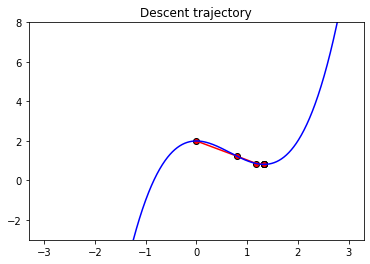

In [6]:
find_minimum_first_order(0.3)

In [7]:
find_minimum_first_order(0.6)

OverflowError: (34, 'Result too large')

Ууупс, получили Overflow. Значит learning rate слишком большой. Хотя большой learning rate опасен возможностью overflow у него есть ряд преимуществ. Чем больше темп обучения, тем большие расстояния мы преодолеваем за один шаг и тем выше вероятность быстрее найти хорошее пространство локальных минимумов.

Хорошая стратегия — начинать с достаточно большого шага (чтобы хорошо попутешествовать по функции), а потом постепенно его уменьшать, чтобы стабилизировать процесс обучения в каком-то локальном минимуме.

Найденный локальный минимум: 1.294744839667743
Количество шагов: 7


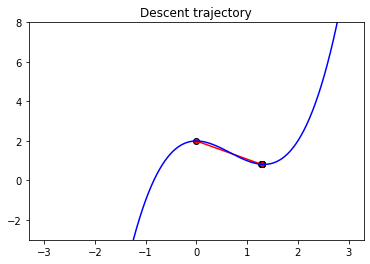

In [8]:
find_minimum_first_order(0.6, anneal_learning_rate=lambda lr, step: 0.3 * lr)

# Описание алгоритмов градиентного спуска

### SGD
SGD - этот же самый gradient descent, что мы рассматривали ранее, вот только подсчёт градиентов производится не по всему множеству данных, а по отдельно взятому сэмплу. Очевидно, такая оптимизация будет очень шумной, что усложнит обучение модели. Поэтому обычно используют MiniBatch-SGD, где вместо одного сэмпла мы берём $k$ семплов. У такого подхода есть несколько плюсов:

* ниже variance в сравнении с обычным SGD, что приводит к более стабильному процессу оптимизации
* хорошо работает с DL библиотеками, так как теперь мы работаем с матрицами

$$
\begin{eqnarray}
g &=& \frac{1}{m}\nabla_w \sum_i L(f(x_{i};w), y_{i}) \\
w &=& w - \eta \times g
\end{eqnarray}
$$

### SGD with Momentum

![Momentum.png](Momentum.png)

Попытаемся добавить SGD эффект инерции. Теперь, вместо того чтобы двигаться строго в направлении градиента в каждой точке, мы стараемся продолжить движение в том же направлении, в котором двигались ранее. То есть у нашей точки, которая спускается по многомерной поверхности, появляется импульс (momentum), который контролируется при помощи параметра $\alpha$. Он определяет какую часть прошлого градиента мы хотим использовать на текущем шаге.
$$
\begin{eqnarray}
g_{t} &=& \alpha g_{t-1} + \eta \frac{1}{m}\nabla_w \sum_i L(f(x_{i};w), y_{i}) \\
w &=& w - \eta \times g
\end{eqnarray}
$$

## Адаптивные варианты градиентного спуска
Во всех предыдущих алгоритмах у нас был фиксированный learning rate. Начиная с Adagrad у нас будет идти алгоритмы, которые подстраивают learning rate в зависимости от обучения. Они называются адаптивными вариантами градиентного спуска.

Адаптивные варианты градиентного спуска подстраивает темп обучения таким образом, чтобы делать большие или маленькие обновления отдельных параметров. Например, может так сложиться, что некоторые веса близки к своим локальным минимумам, тогда по этим координатам нужно двигаться медленнее, а другие веса ещё только в середине, значит их можно менять гораздо быстрее. Подобные методы часты приводят к более обоснованной модели и сходятся гораздо быстрее.

### Adagrad
$$
\begin{eqnarray}
g &=& \frac{1}{m}\nabla_w \sum_i L(f(x_{i};w), y_{i}) \\
s &=& s + diag(gg^{T}) \\
w &=& w - \frac{\eta}{\sqrt{s+eps}} \odot g
\end{eqnarray}
$$
Теперь нам не нужно сильно волноваться о правильном подборе $\eta$, так как $s$ контролирует скорость обучения для каждого параметра.

### RMSprop
У Adagrad есть сильный минус. $s$ - всегда положительна и постоянно растёт во время обучения, что приводит к ситуации, когда у нас learning rate становится слишком маленький, и мы перестаём учиться. RMSprop исправляет эту проблему при помощи экспоненциального сглаживания
$$
\begin{eqnarray}
g &=& \frac{1}{m}\nabla_w \sum_i L(f(x_{i};w), y_{i}) \\
s &=& \rho s + (1 - \rho) diag(gg^{T}) \\
w &=& w - \frac{\eta}{\sqrt{s+eps}} \odot g
\end{eqnarray}
$$

### Adam
Добавим не только моменты второго порядка, но и первого при обновлении параметров
$$
\begin{eqnarray}
g &=& \frac{1}{m}\nabla_w \sum_i L(f(x_{i};w), y_{i}) \\
m &=& \beta_1 m + (1 - \beta_1) g \\
v &=& \beta_2 v + (1 - \beta_2) diag(gg^{T}) \\
\hat{m} &=& \frac{m}{1 - \beta_1^{t}} \\
\hat{v} &=& \frac{v}{1 - \beta_2^{t}} \\
w &=& w - \frac{\eta}{\sqrt{\hat{v} + \epsilon}} \odot \hat{m}
\end{eqnarray}
$$

### Схема
<div>
<img src="Modifications.png" width="300"/>
</div>

# PyTorch Optimizer
Очевидно, что для своих нейронных сетей не нужно каждый раз писать свой алгоритм и за вас уже сделаны все самые популярные методы. Их можно найти в **torch.optim**.

In [9]:
[elem for elem in dir(torch.optim) if not elem.startswith("_")]

['ASGD',
 'Adadelta',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'LBFGS',
 'Optimizer',
 'RMSprop',
 'Rprop',
 'SGD',
 'SparseAdam',
 'lr_scheduler',
 'swa_utils']

Основные функции PyTorch Optimizer:
* __step__ - обновление весов модели
* __zero_grad__ - занулить веса модели (по умолчанию градиенты в PyTorch аккумулируются) ~ `for each param in params: param.grad = None`
* __state_dict__ - получить текущее состояние Optimizer. Для адаптивных методов тут будут храниться аккумулированные квадраты градиентов

## Как сделать instance PyTorch Optimizer?
Достаточно передать параметры модели (их можно получить при помощи функции `parameters()`) и гипер-параметоры для метода оптимизации.

Пример:

In [10]:
?torch.optim.SGD

In [11]:
model = torch.nn.Linear(1, 1)
list(model.parameters()), torch.optim.SGD(model.parameters(), lr=0.01)

([Parameter containing:
  tensor([[0.3620]], requires_grad=True),
  Parameter containing:
  tensor([0.7337], requires_grad=True)],
 SGD (
 Parameter Group 0
     dampening: 0
     lr: 0.01
     momentum: 0
     nesterov: False
     weight_decay: 0
 ))

Или же вот так

In [12]:
# Зададим PyTorch модули в качестве словаря
model = torch.nn.ModuleDict({
    "linear_1": torch.nn.Linear(1, 1),
    "linear_2": torch.nn.Linear(2, 2)
})
torch.optim.SGD([
    {"params": model["linear_1"].parameters(), "lr": 0.3},
    {"params": model["linear_2"].parameters()}
], lr=0.5)

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.3
    momentum: 0
    nesterov: False
    weight_decay: 0

Parameter Group 1
    dampening: 0
    lr: 0.5
    momentum: 0
    nesterov: False
    weight_decay: 0
)

Последнее очень полезно для Transfer Learning, когда мы хотим, чтобы предобученная модель тренировалась с другим learning rate

## Делаем свой Optimizer
Для того чтобы сделать свой Optimizer, не нужно писать свою имплементацию каждой из основных функций. Достаточно переопределить только одну из них - **step**.

Попробуем реализовать несколько своих Optimizer. В качестве данных для модели воспользуемся `make_regression` из `sklearn`.

In [13]:
from sklearn.datasets import make_regression


def seed_everything(seed):
    # Зафиксировать seed.
    # Это понадобится, чтобы убедиться
    # в правильности работы нашего Optimizer
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


# make_regression возвращает 2 переменные: данные и таргет для них
# так как они возвращаётся как np.array,
# вызовем для каждого из них команду torch.from_numpy
X, y = map(
    lambda x: torch.from_numpy(x).float(),
    make_regression(n_samples=200, n_features=2)
)


def get_model():
    # Таким образом, мы при каждом вызове будем получить
    # модель с одной и той же инициализацией весов
    seed_everything(13)
    return torch.nn.Sequential(
        torch.nn.Linear(2, 10),
        torch.nn.Linear(10, 1)
    )

Как мы заметили ранее Optimizer работает с группами параметров. Поэтому нам необходимо делать отдельно update для каждой группы параметров (-> ещё один for loop)

In [14]:
from torch.optim import Optimizer


class InClassOptimizer(Optimizer):
    def step(self):
        """Perform a single optimization step."""
        with torch.no_grad(): # выключим градиенты
            for group in self.param_groups:
                self._group_step(group)

    def _group_step(self, group):
        # group ~ dict[str, ...]
        """
        Private helper function to perform
        single optimization step on model parameters.
        """
        raise NotImplementedError()

In [15]:
class Adagrad(InClassOptimizer):
    def __init__(self, params, lr=0.001, eps=1e-13):
        defaults = dict(lr=lr, eps=eps)
        super().__init__(params, defaults)

    def _group_step(self, group):
        # One group contains information about values passed in init
        # and model parameters to update
        lr = group["lr"]
        eps = group["eps"]
        for param in filter(lambda x: x.grad is not None, group["params"]):
            # TODO:
            # Your code here
            # --------------
            self._init_adagrad_buffer(param)
            d_param = param.grad
            buffer = self._get_adagrad_buffer(param)
            buffer.add_(d_param ** 2)
            d_param /= torch.sqrt(buffer + eps)
            # Inplace update of params multiplied by -lr
            param.add_(d_param, alpha=-lr)
            # --------------

    def _get_adagrad_buffer(self, param):
        """
        Get accumulated gradients for Adagrad.

        Parameters
        ----------
        param : `torch.Tensor`, required
            Model parameter to get accumulated gradeints for Adagrad.

        Returns
        -------
        Accumulated Adagrad gradients for parameter.
        """
        param_state = self.state[param]
        
        return param_state["adagrad_buffer"]

    def _init_adagrad_buffer(self, param):
        """
        Initialize accumulated gradeints for SGD momentum.

        Parameters
        ----------
        param : `torch.Tensor`, required
            Model parameter to get accumulated gradeints for Adagrad.
        """
        param_state = self.state[param]
        if "adagrad_buffer" not in param_state:
            param_state["adagrad_buffer"] = torch.zeros_like(param)

In [16]:
def check_optimizer(model, optim, num_iter):
    loss = torch.nn.MSELoss()
    for i in range(num_iter):
        output = loss(model(X), y.unsqueeze(-1))
        output.backward()
        optim.step()
        optim.zero_grad()
        if i % 100 == 0:
            print(f"Iteration {i} loss: {output.item()}")

Проверим, что написанный Optimizer работает корректно

In [17]:
model = get_model()
optim = Adagrad(model.parameters(), lr=0.001)
check_optimizer(model, optim, num_iter=1000)

Iteration 0 loss: 2803.320556640625
Iteration 100 loss: 2789.825927734375
Iteration 200 loss: 2783.95849609375
Iteration 300 loss: 2779.49853515625
Iteration 400 loss: 2775.7607421875
Iteration 500 loss: 2772.4775390625
Iteration 600 loss: 2769.51318359375
Iteration 700 loss: 2766.786865234375
Iteration 800 loss: 2764.246337890625
Iteration 900 loss: 2761.857177734375


In [18]:
model = get_model()
optim = torch.optim.Adagrad(model.parameters(), lr=0.001)
check_optimizer(model, optim, num_iter=1000)

Iteration 0 loss: 2803.320556640625
Iteration 100 loss: 2789.825927734375
Iteration 200 loss: 2783.95849609375
Iteration 300 loss: 2779.49853515625
Iteration 400 loss: 2775.7607421875
Iteration 500 loss: 2772.4775390625
Iteration 600 loss: 2769.51318359375
Iteration 700 loss: 2766.786865234375
Iteration 800 loss: 2764.246337890625
Iteration 900 loss: 2761.857177734375


Почему такой большой лосс?

Если посмотреть на optim.state, то сразу становится ясно, что квадраты градиентов очень большие, следовательно, апдейт будет совсем небольшой.

Повысим learning rate и посмотрим на поведение модели.

In [19]:
model = get_model()
optim = Adagrad(model.parameters(), lr=0.1)
check_optimizer(model, optim, num_iter=1000)

Iteration 0 loss: 2803.320556640625
Iteration 100 loss: 48.26877975463867
Iteration 200 loss: 0.12364918738603592
Iteration 300 loss: 0.00025058610481210053
Iteration 400 loss: 5.303460284267203e-07
Iteration 500 loss: 7.903008025778036e-09
Iteration 600 loss: 6.416297715361452e-09
Iteration 700 loss: 6.416297715361452e-09
Iteration 800 loss: 6.416297715361452e-09
Iteration 900 loss: 6.416297715361452e-09


`Какая мораль?`

Даже если у вас есть методы с адаптивным градиентом спуском, полностью забывать о настройке learning rate не стоит.

## Сравнение методов оптимизации

In [20]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


# Train data
fashion_mnist_train = torchvision.datasets.FashionMNIST(
    "./data",
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)
train_dataloader = DataLoader(
    fashion_mnist_train, 
    batch_size=128, 
    shuffle=True, 
    num_workers=2
)

# Validation data
fashion_mnist_eval = torchvision.datasets.FashionMNIST(
    "./data",
    train=False,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)
eval_dataloader = DataLoader(
    fashion_mnist_eval, 
    batch_size=128, 
    num_workers=2
)

In [21]:
from collections import defaultdict


idx_to_label = defaultdict(lambda: None, {
    0: "T-shirt/Top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot"
})

In [22]:
class Accuracy:
    def __init__(self):
        self._all_predictions = torch.LongTensor()
        self._all_labels = torch.LongTensor()

    def __call__(self, predictions, labels):
        # predictions ~ (batch size)
        # labels ~ (batch size)
        self._all_predictions = torch.cat([
            self._all_predictions,
            predictions
        ], dim=0)
        self._all_labels = torch.cat([
            self._all_labels,
            labels
        ], dim=0)

    def get_metric(self, reset=False):
        correct = (self._all_predictions == self._all_labels).long()
        accuracy = correct.sum().float() / self._all_labels.size(0)
        if reset:
            self.reset()
        return accuracy

    def reset(self):
        self._all_predictions = torch.LongTensor()
        self._all_labels = torch.LongTensor()

# Модель

1. BatchNorm
2. Conv(out=32, kernel=3) -> ReLu -> MaxPool(kernel=2)
3. Conv(out=64, kernel=3) -> ReLu -> MaxPool(kernel=2)
4. Flatten
5. Linear(out=128)
6. ReLu
7. Dropout
8. Linear(out=64)
9. ReLu
10. Linear(out=10)



In [23]:
class SimpleNetEncoder(torch.nn.Module):
    def __init__(self, dropout=0.4):
        super().__init__()
        # TODO:
        # Your code here:
        # --------------
        self.batch_norm = torch.nn.BatchNorm2d(1)
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
        )
        self.linear1 = torch.nn.Linear(in_features=64 * 5 * 5, out_features=128)
        self.linear2 = torch.nn.Linear(in_features=128, out_features=64)
        self.output = torch.nn.Linear(in_features=64, out_features=10)
        self.dropout = torch.nn.Dropout(p=dropout)
        # --------------

    def forward(self, x):
        # TODO:
        # Your code here:
        # --------------
        x = self.batch_norm(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.linear1(x))
        x = self.dropout(x)
        x = F.relu(self.linear2(x))
        
        return self.output(x)
        # --------------


class SimpleNet(torch.nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self._encoder = encoder
        self._accuracy = Accuracy()

    def forward(self, images, target=None):
        # images ~ (batch size, num channels, height, width)
        # target ~ (batch size)
        # output ~ (batch size, num classes)
        output = self._encoder(images)
        output_dict = {"logits": output, "probs": torch.softmax(output, dim=-1)}
        output_dict["preds"] = torch.argmax(output_dict["probs"], dim=-1)
        if target is not None:
            # CrossEntropy Loss
            log_softmax = torch.log_softmax(output, dim=-1)
            output_dict["loss"] = F.nll_loss(log_softmax, target)
            self._accuracy(
                output_dict["preds"].cpu(),
                target.cpu()
            )
        return output_dict

    def decode(self, output_dict):
        # output_dict ~ dict with torch.Tensors (output_dict from forward)
        return [idx_to_label[int(x)] for x in output_dict["preds"]]

    def get_metrics(self, reset=False):
        return {"accuracy": self._accuracy.get_metric(reset)}

In [24]:
def train_epoch(
    model,
    data_loader,
    optimizer,
    return_losses=False,
    device="cuda:0",
):
    model = model.train()
    total_loss = 0
    num_batches = 0
    all_losses = []
    with tqdm(total=len(data_loader), file=sys.stdout) as prbar:
        for batch in data_loader:
            # Move Batch to GPU
            batch = [x.to(device=device) for x in batch]
            output_dict = model(*batch)
            loss = output_dict["loss"]
            # Update weights
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # Update descirption for tqdm
            metrics = model.get_metrics()
            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(metrics['accuracy'].item() * 100, 4)}"
            )
            prbar.update(1)
            total_loss += loss.item()
            num_batches += 1
            all_losses.append(loss.detach().item())
    metrics = {"loss": total_loss / num_batches}
    metrics.update(model.get_metrics(reset=True))
    if return_losses:
        return metrics, all_losses
    else:
        return metrics


def validate(model, data_loader, device="cuda:0"):
    model = model.eval()
    total_loss = 0
    num_batches = 0
    with tqdm(total=len(data_loader), file=sys.stdout) as prbar:
        for batch in data_loader:
            batch = [x.to(device=device, non_blocking=True) for x in batch]
            output_dict = model(*batch)
            loss = output_dict['loss']
            metrics = model.get_metrics()
            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(metrics['accuracy'].item() * 100, 4)}"
            )
            prbar.update(1)
            total_loss += loss.item()
            num_batches += 1
    metrics = {"loss": total_loss / num_batches}
    metrics.update(model.get_metrics(reset=True))
    return metrics

In [25]:
from collections import namedtuple


LossInfo = namedtuple(
    "LossInfo", 
    ["full_train_losses", "train_epoch_losses", "eval_epoch_losses"]
)


EPOCHS = 7
LR = 0.001

In [26]:
def fit(
    model,
    epochs,
    train_data_loader,
    validation_data_loader,
    optimizer,
    device
):
    all_train_losses = []
    epoch_train_losses = []
    epoch_eval_losses = []
    for epoch in range(epochs):
        # Construct iterators
        train_iterator = iter(train_data_loader)
        validation_iterator = iter(validation_data_loader)
        # Train step
        print(f"Train Epoch: {epoch}")
        train_metrics, one_epoch_train_losses = train_epoch(
            model=model,
            data_loader=train_iterator,
            optimizer=optimizer,
            return_losses=True,
            device=device
        )
        # Save Train losses
        all_train_losses.extend(one_epoch_train_losses)
        epoch_train_losses.append(train_metrics["loss"])
        # Eval step
        print(f"Validation Epoch: {epoch}")
        with torch.no_grad():
            validation_metrics = validate(
                model=model,
                data_loader=validation_iterator,
                device=device
            )
        # Save eval losses
        epoch_eval_losses.append(validation_metrics["loss"])
    return LossInfo(all_train_losses, epoch_train_losses, epoch_eval_losses)

SGD

In [27]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

model = SimpleNet(encoder=SimpleNetEncoder()).to(device=device)
sgd_loss_info = fit(
    model=model,
    epochs=EPOCHS,
    train_data_loader=train_dataloader,
    validation_data_loader=eval_dataloader,
    optimizer=torch.optim.SGD(model.parameters(), lr=LR),
    device=device
)

Train Epoch: 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation Epoch: 0


  0%|          | 0/79 [00:00<?, ?it/s]

Train Epoch: 1


  0%|          | 0/469 [00:00<?, ?it/s]

Validation Epoch: 1


  0%|          | 0/79 [00:00<?, ?it/s]

Train Epoch: 2


  0%|          | 0/469 [00:00<?, ?it/s]

Validation Epoch: 2


  0%|          | 0/79 [00:00<?, ?it/s]

Train Epoch: 3


  0%|          | 0/469 [00:00<?, ?it/s]

Validation Epoch: 3


  0%|          | 0/79 [00:00<?, ?it/s]

Train Epoch: 4


  0%|          | 0/469 [00:00<?, ?it/s]

Validation Epoch: 4


  0%|          | 0/79 [00:00<?, ?it/s]

Train Epoch: 5


  0%|          | 0/469 [00:00<?, ?it/s]

Validation Epoch: 5


  0%|          | 0/79 [00:00<?, ?it/s]

Train Epoch: 6


  0%|          | 0/469 [00:00<?, ?it/s]

Validation Epoch: 6


  0%|          | 0/79 [00:00<?, ?it/s]


SGD with Momentum

In [28]:
model = SimpleNet(encoder=SimpleNetEncoder()).to(device=device)
sgd_momentum_loss_info = fit(
    model=model,
    epochs=EPOCHS,
    train_data_loader=train_dataloader,
    validation_data_loader=eval_dataloader,
    optimizer=torch.optim.SGD(model.parameters(), momentum=0.9, lr=LR),
    device=device
)

Train Epoch: 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation Epoch: 0


  0%|          | 0/79 [00:00<?, ?it/s]

Train Epoch: 1


  0%|          | 0/469 [00:00<?, ?it/s]

Validation Epoch: 1


  0%|          | 0/79 [00:00<?, ?it/s]

Train Epoch: 2


  0%|          | 0/469 [00:00<?, ?it/s]

Validation Epoch: 2


  0%|          | 0/79 [00:00<?, ?it/s]

Train Epoch: 3


  0%|          | 0/469 [00:00<?, ?it/s]

Validation Epoch: 3


  0%|          | 0/79 [00:00<?, ?it/s]

Train Epoch: 4


  0%|          | 0/469 [00:00<?, ?it/s]

Validation Epoch: 4


  0%|          | 0/79 [00:00<?, ?it/s]

Train Epoch: 5


  0%|          | 0/469 [00:00<?, ?it/s]

Validation Epoch: 5


  0%|          | 0/79 [00:00<?, ?it/s]

Train Epoch: 6


  0%|          | 0/469 [00:00<?, ?it/s]

Validation Epoch: 6


  0%|          | 0/79 [00:00<?, ?it/s]

RMSprop

In [29]:
model = SimpleNet(encoder=SimpleNetEncoder()).to(device=device)
rmsprop_loss_info = fit(
    model=model,
    epochs=EPOCHS,
    train_data_loader=train_dataloader,
    validation_data_loader=eval_dataloader,
    optimizer=torch.optim.RMSprop(model.parameters(), lr=LR),
    device=device
)

Train Epoch: 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation Epoch: 0


  0%|          | 0/79 [00:00<?, ?it/s]

Train Epoch: 1


  0%|          | 0/469 [00:00<?, ?it/s]

Validation Epoch: 1


  0%|          | 0/79 [00:00<?, ?it/s]

Train Epoch: 2


  0%|          | 0/469 [00:00<?, ?it/s]

Validation Epoch: 2


  0%|          | 0/79 [00:00<?, ?it/s]

Train Epoch: 3


  0%|          | 0/469 [00:00<?, ?it/s]

Validation Epoch: 3


  0%|          | 0/79 [00:00<?, ?it/s]

Train Epoch: 4


  0%|          | 0/469 [00:00<?, ?it/s]

Validation Epoch: 4


  0%|          | 0/79 [00:00<?, ?it/s]

Train Epoch: 5


  0%|          | 0/469 [00:00<?, ?it/s]

Validation Epoch: 5


  0%|          | 0/79 [00:00<?, ?it/s]

Train Epoch: 6


  0%|          | 0/469 [00:00<?, ?it/s]

Validation Epoch: 6


  0%|          | 0/79 [00:00<?, ?it/s]

Adam

In [ ]:
model = SimpleNet(encoder=SimpleNetEncoder()).to(device=device)
adam_loss_info = fit(
    model=model,
    epochs=EPOCHS,
    train_data_loader=train_dataloader,
    validation_data_loader=eval_dataloader,
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    device=device
)

Train Epoch: 0


  0%|          | 0/469 [00:00<?, ?it/s]

Validation Epoch: 0


  0%|          | 0/79 [00:00<?, ?it/s]

Train Epoch: 1


  0%|          | 0/469 [00:00<?, ?it/s]

In [ ]:
plt.plot(
    np.arange(len(train_dataloader) * EPOCHS),
    sgd_loss_info.full_train_losses,
    label="SGD", c="grey"
)
plt.plot(
    np.arange(len(train_dataloader) * EPOCHS),
    sgd_momentum_loss_info.full_train_losses,
    label="SGD Momentum", c="blue"
)
plt.plot(
    np.arange(len(train_dataloader) * EPOCHS),
    rmsprop_loss_info.full_train_losses,
    label="RMSProp", c="green"
)
plt.plot(
    np.arange(len(train_dataloader) * EPOCHS),
    adam_loss_info.full_train_losses,
    label="Adam", c="red"
)
plt.legend()
plt.show()

In [ ]:
plt.plot(
    np.arange(EPOCHS), sgd_loss_info.eval_epoch_losses,
    label="SGD", c="grey"
)
plt.plot(
    np.arange(EPOCHS), sgd_momentum_loss_info.eval_epoch_losses,
    label="SGD Momentum", c="blue"
)
plt.plot(
    np.arange(EPOCHS), rmsprop_loss_info.eval_epoch_losses,
    label="RMSprop", c="green"
)
plt.plot(
    np.arange(EPOCHS), adam_loss_info.eval_epoch_losses,
    label="Adam", c="red"
)
plt.legend()
plt.show()

## Оптимизация второго порядка
Теперь вернёмся немного назад к функции $f(x)$ и рассмотрим оптимизацию второго порядка [методом Ньютона](https://streletzcoder.ru/nahozhdenit-lokalnyih-ekstremumov-funktsiy-s-pomoshhyu-metoda-nyutona/). Вместо того чтобы приближать функцию в текущей точке линейно можно это делать при помощи квадратов.

In [ ]:
d_2_func = lambda x: 6 * x - 4

In [ ]:
def find_minimum_second_order(eps=1e-4, max_iterations=1000):
    i = 0
    x_old, x_new = 0, 2
    x_list, y_list = [x_old], [func(x_old)]
    while abs(x_new - x_old) > eps and i < max_iterations:
        # Обновим x_old
        x_old = x_new
        # Сделаем один шаг gradient descent со 2 порядком градиентов
        x_new = x_old - d_func(x_old) / d_2_func(x_old)
        # Сохраним значения для визуализации
        x_list.append(x_new)
        y_list.append(func(x_new))
        i += 1
    print("Найденный локальный минимум:", x_new)
    print("Количество шагов:", len(x_list))
    # Визуализируем сходимость
    plt.figure(figsize=[6, 4])
    plt.ylim([-3, 8])
    plt.scatter(x_list, y_list, c="r", edgecolors="k")
    plt.plot(x_list, y_list, c="r")
    plt.plot(x, func(x), c="b")
    plt.title("Descent trajectory")
    plt.show()

In [ ]:
find_minimum_second_order()

В итоге мы пришли к минимуму гораздо быстрее. И если же методы второго порядка такие крутые и быстрые, то почему их не используют в нейронных сетях? Для ответа на этот вопрос сначала рассмотрим плюсы и минусы данного подхода.

Плюсы методов второго порядка:
* Быстрее, чем методы оптимизации первого порядка
* Нет необходимости настраивать learning_rate

Можете ли вы предположить минусы методов оптимизации второго порядка или же просто методов Ньютона?

Ответ:
* Сложность вычисления градиента второго порядка
* В многомерном случае необходимо хранить матрицу размерности N x N

Проблема с памятью наиболее острая, так как современные нейронные сети имеют миллионы параметров и хранить матрицу миллион на миллион очень сложно.

## Зачем мы вообще начали разговор о 2 порядке?
Ответ в том, что методы с адаптивными градиентным являются аппроксимацией методов 2 порядка. Отсюда становится понятно, почему мы делим на матрицу квадратов в Adagrad и других его модификациях
$$
\mathbb{E}[gg^{T}] \sim \mathbb{E}[H(x)]
$$
Здесь:
* $gg^{T}$ - квадратная матрица квадратов градиентов
* $\mathbb{E}[H(x)]$ - ожидаемое значение Гессиана (матрица градиентов 2 порядка). В адаптивном градиенте разница лишь в том, что мы берём $\sqrt{diag(gg^{T})}$, так как $gg^{T}$ занимает слишком много места.